### Mini-guía práctica 

- Capas ocultas: empieza con **ReLU** (baseline).
- Si ves neuronas ‘muertas’: prueba **LeakyReLU** o **GELU**.
- Salida: depende del problema (veremos en regresión vs clasificación).

| Activación | Rango          | Dónde usarla                 | Para qué sirve                  | Riesgos                  |
| ---------- | -------------- | ---------------------------- | ------------------------------- | ------------------------ |
| ReLU       | [0, +inf)      | Capas ocultas en CNN, MLP    | Rápida, estable                 | Neuronas muertas         |
| Leaky ReLU | (-inf, +inf)   | Capas ocultas si ReLU falla  | Mantiene gradiente en negativos | Un poco de ruido         |
| GELU       | (-inf, +inf)   | Transformers, NLP, ViT       | Flujo suave de gradientes       | Más costosa              |
| Tanh       | (-1, 1)        | Redes pequeñas, RNN clásicas | Centrada en cero                | Se satura                |
| Sigmoid    | (0, 1)         | Salida binaria               | Probabilidad                    | Vanishing gradient       |
| Softmax    | (0, 1), suma=1 | Salida multiclase            | Distribución de probabilidad    | No usar en capas ocultas |


## ¿Qué optimizador usar y cuándo?

Los optimizadores controlan cómo los parámetros del modelo se mueven para minimizar la función de pérdida.

| Optimizador | Qué hace | Cuándo usarlo | Ventajas | Riesgos |
|-------------|--------|--------------|---------|--------|
| SGD | Da pasos en la dirección del gradiente | Modelos pequeños, datasets limpios | Simple, estable | Lento |
| SGD + Momentum | Usa velocidad acumulada | Redes profundas, visión | Converge más rápido | Puede oscilar |
| Nesterov | Momentum "anticipado" | CNNs, visión | Más preciso | Sensible a lr |
| Adam | Ajusta lr por parámetro | NLP, Transformers, datos ruidosos | Rápido, robusto | Puede sobreajustar |
| AdamW | Adam + regularización correcta | LLMs, Transformers modernos | Mejor generalización | Algo más costoso |
| RMSprop | Escala por varianza | RNNs, series temporales | Estable | Menos usado hoy |

## Regla práctica
- **CNNs / visión → SGD + Momentum**
- **Transformers / NLP → AdamW**
- **Prototipos rápidos → Adam**
- **Datos ruidosos → Adam o RMSprop**
- **Producción final → SGD + Momentum**


# MINIMIZAR UNA FUNCIÓN: USANDO OPTIMIZADOR


 Conceptos:
   - nn.Parameter: tensor entrenable (PyTorch lo trata como parámetro del modelo).
   - optimizer = torch.optim.SGD([...], lr=...)
   - optimizer.zero_grad(): limpia gradientes
   - loss.backward(): calcula gradientes
   - optimizer.step(): actualiza parámetros

Herencia real en PyTorch: `nn.Module`

Puntos clave:

- `super().__init__()` inicializa el módulo padre.
- Todo `nn.Linear`, `nn.Conv2d`, etc. que declares como atributo queda **registrado**.
- `model.parameters()` encuentra automáticamente los parámetros entrenables.

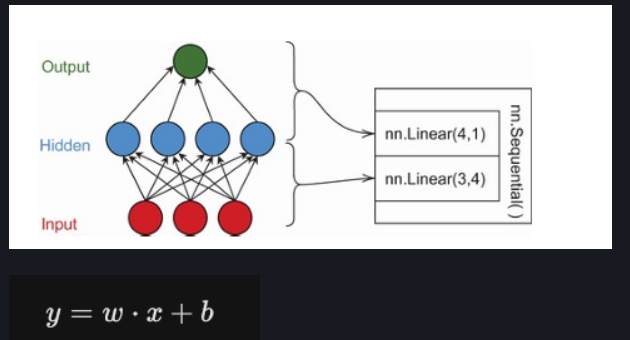

- En PyTorch, SIEMPRE heredas de nn.Module.
- Definir capas en __init__ "registra" parámetros entrenables.
 - forward define cómo pasan los datos por esas capas.

| Funcionalidad          | Qué hace                                   |
| ---------------------- | ------------------------------------------ |
| `.parameters()`        | Devuelve todos los pesos entrenables       |
| `.to(device)`          | Mueve todo el modelo a CPU o GPU           |
| `.cuda()`              | Mueve a GPU                                |
| `.train()` / `.eval()` | Cambia comportamiento (Dropout, BatchNorm) |
| `.state_dict()`        | Serializa pesos                            |
| `.load_state_dict()`   | Carga pesos                                |
| `.modules()`           | Recorre subcapas                           |
| `backward()`           | Autograd funciona correctamente            |


# Solucion TAREA

## que hacer

En este reto van a construir un modelo de Deep Learning híbrido para clasificar actividades humanas a partir de series de tiempo multivariadas.

Dataset:  https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

Reglas o condiciones:

1- La arquitectura debe integrar:

    - capas cnn-1d para extraer patrones temporales

    - MLP para clasificar

3- deben implementar:

    -Dataset + DataLoader

    -División train / validation/ test

    -Loop de entrenamiento

4- Cálculo de:

    -loss

    -accuracy

    -Early stopping y selección del mejor modelo

5- Deben generar Gráficas:

    -train_loss vs epoch

    -val_loss vs epoch

    -train_accuracy vs epoch

    -val_accuracy vs epoch

6- Guardar modelo

## Solucion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
import torch.nn as nn


una fila = una ventana temporal = 128 muestras

In [2]:
x = np.loadtxt(r"UCI HAR Dataset\UCI HAR Dataset\train\Inertial Signals\body_acc_x_train.txt")
print(x.shape)

(7352, 128)


= 7352 ventanas, cada una de 128 pasos

In [3]:
x.mean(), x.std()

(np.float64(-0.000636303057857952), np.float64(0.19484633958319697))

forma temporal

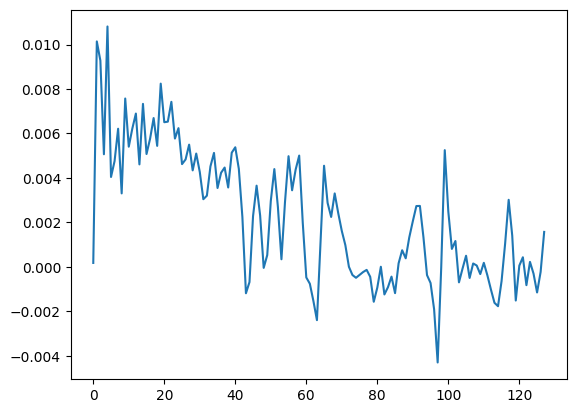

In [4]:
plt.plot(x[0])

cargar señales inerciales

| Sensor    | Tipo                                  | Ejes    |
| --------- | ------------------------------------- | ------- |
| body_acc  | aceleración del cuerpo (sin gravedad) | x, y, z |
| total_acc | aceleración total (con gravedad)      | x, y, z |
| body_gyro | velocidad angular                     | x, y, z |


- 3 sensores × 3 ejes = 9 señales 
- 9 señales × 128 pasos de tiempo


In [5]:
def load_inertial_signals(base_path, split="train"):
    signals_path = os.path.join(
        base_path, split, "Inertial Signals"
    )

    signal_files = [
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
        "total_acc_x_", "total_acc_y_", "total_acc_z_"
    ]

    signals = []
    for sig in signal_files:
        file = os.path.join(signals_path, f"{sig}{split}.txt")
        data = np.loadtxt(file)
        signals.append(data)

    # shape: (N, 9, 128)
    X = np.stack(signals, axis=1)
    return torch.tensor(X, dtype=torch.float32)

cargar labels

In [6]:
def load_labels(base_path, split="train"):
    y_path = os.path.join(base_path, split, f"y_{split}.txt")
    y = np.loadtxt(y_path).astype(int) - 1  # clases 0–5
    return torch.tensor(y, dtype=torch.long)

cargar el dataset

In [7]:
BASE_PATH = r"C:\Users\isape\OneDrive\Escritorio\ANALITICA\Sesion 1 DL- Intro pytorch\tarea_DL1_clasi_acti_humanas\UCI HAR Dataset\UCI HAR Dataset"

X_train = load_inertial_signals(BASE_PATH, "train")
y_train = load_labels(BASE_PATH, "train")

X_test = load_inertial_signals(BASE_PATH, "test")
y_test = load_labels(BASE_PATH, "test")

print(X_train.shape)  # (7352, 9, 128)
print(y_train.shape)  # (7352,)

torch.Size([7352, 9, 128])
torch.Size([7352])


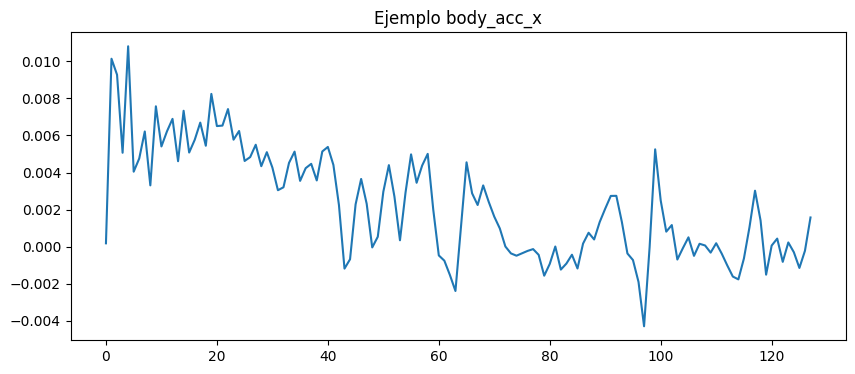

In [8]:
plt.figure(figsize=(10,4))
plt.plot(X_train[0, 0])  # body_acc_x
plt.title("Ejemplo body_acc_x")
plt.show()


## Datasets y DataLoaders en PyTorch

PyTorch separa el manejo de datos en dos conceptos clave:

| Componente | Qué hace |
|-----------|---------|
| `Dataset` | Define **cómo acceder a los datos** (qué es una muestra, cómo leerla, cómo transformarla) |
| `DataLoader` | Se encarga de **cargar datos en batches**, barajarlos y paralelizar la lectura |


### Dataset

Un `Dataset` es una clase que representa tu conjunto de datos.  
Debe implementar dos métodos:

- `__len__()` → cuántas muestras hay  
- `__getitem__(i)` → devuelve la muestra `i`

In [9]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

split train/val

In [10]:
dataset_full = HARDataset(X_train, y_train)

train_size = int(0.8 * len(dataset_full))
val_size = len(dataset_full) - train_size

train_ds, val_ds = random_split(dataset_full, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(HARDataset(X_test, y_test), batch_size=64)

### modelo hibrido 1D cnn y mlp

arquitectura

Input (9 × 128)
 → Conv1D → Conv1D → Pooling
 → Flatten
 → MLP
 → Softmax (implícito en CrossEntropyLoss)


modelo


¿128×32?
128 pasos → pool /2 → 64 → pool /2 → 32

In [11]:
class CNN1D_MLP(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()

        # CNN para patrones temporales
        self.cnn = nn.Sequential(
            nn.Conv1d(9, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )

        # tamaño calculado manualmente
        self.flatten = nn.Flatten()
        flat_dim = 128 * 32  # ← CLAVE

        # MLP para clasificación
        self.fc = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


### entrenar

accuracy

In [12]:
def accuracy(preds, y):
    preds = torch.argmax(preds, dim=1)
    return (preds == y).float().mean().item()


loop por epoca

In [13]:
def train_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(Xb)
        loss = loss_fn(preds, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)
        total_acc += accuracy(preds, yb) * Xb.size(0)

    n = len(loader.dataset)
    return total_loss / n, total_acc / n


In [14]:
@torch.no_grad()
def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        preds = model(Xb)
        loss = loss_fn(preds, yb)

        total_loss += loss.item() * Xb.size(0)
        total_acc += accuracy(preds, yb) * Xb.size(0)

    n = len(loader.dataset)
    return total_loss / n, total_acc / n


In [15]:
class EarlyStopping:
    """
    Detiene si val_loss NO mejora tras 'patience' épocas.
    Guarda el mejor state_dict en memoria.
    """
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience      # cuántas épocas esperar sin mejora
        self.min_delta = min_delta    # mejora mínima requerida
        self.best_loss = float("inf")
        self.best_state = None
        self.counter = 0

    def step(self, val_loss, model):
        # ¿mejoró suficiente?
        improved = (self.best_loss - val_loss) > self.min_delta

        if improved:
            self.best_loss = val_loss
            # guardamos una copia de pesos (CPU para seguridad)
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
            return False  # no parar
        else:
            self.counter += 1
            return self.counter >= self.patience  # parar si superó paciencia



In [16]:
early = EarlyStopping(patience=10) # cuántas épocas esperar sin mejora

### entrenamiento completo

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN1D_MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

epochs = 50

for epoch in range(epochs):
    tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, loss_fn, device)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1:02d} | "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

    if early.step(val_loss, model):
        print("⏹ Early stopping")
        break


Epoch 01 | train_loss=0.4440 acc=0.8351 | val_loss=0.1793 acc=0.9354
Epoch 02 | train_loss=0.1617 acc=0.9413 | val_loss=0.1293 acc=0.9456
Epoch 03 | train_loss=0.1499 acc=0.9383 | val_loss=0.1162 acc=0.9565
Epoch 04 | train_loss=0.1329 acc=0.9471 | val_loss=0.1040 acc=0.9572
Epoch 05 | train_loss=0.1309 acc=0.9468 | val_loss=0.1253 acc=0.9504
Epoch 06 | train_loss=0.1291 acc=0.9451 | val_loss=0.0976 acc=0.9606
Epoch 07 | train_loss=0.1209 acc=0.9498 | val_loss=0.0981 acc=0.9579
Epoch 08 | train_loss=0.1186 acc=0.9481 | val_loss=0.0956 acc=0.9572
Epoch 09 | train_loss=0.1165 acc=0.9507 | val_loss=0.1067 acc=0.9585
Epoch 10 | train_loss=0.1187 acc=0.9483 | val_loss=0.1109 acc=0.9585
Epoch 11 | train_loss=0.1164 acc=0.9520 | val_loss=0.0979 acc=0.9558
Epoch 12 | train_loss=0.1143 acc=0.9532 | val_loss=0.0884 acc=0.9653
Epoch 13 | train_loss=0.1118 acc=0.9500 | val_loss=0.1699 acc=0.9293
Epoch 14 | train_loss=0.1190 acc=0.9490 | val_loss=0.0924 acc=0.9633
Epoch 15 | train_loss=0.1123 acc=0

In [18]:
model.load_state_dict(early.best_state)


<All keys matched successfully>

### Graficas

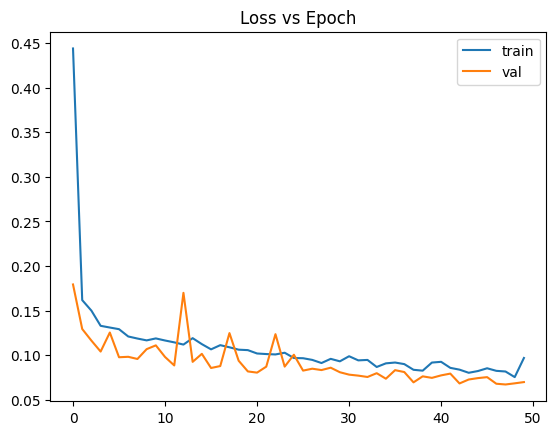

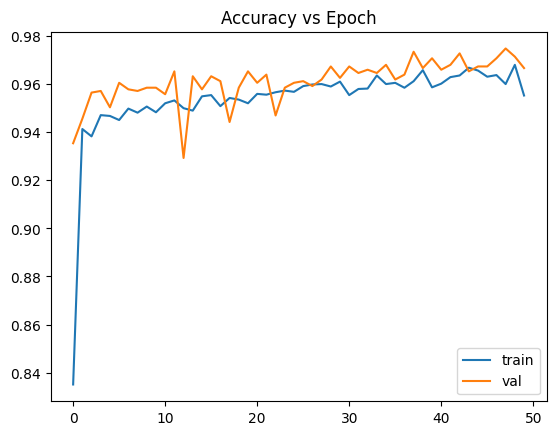

In [19]:
plt.figure()
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.show()


### evaluacion final test

In [20]:
test_loss, test_acc = eval_epoch(model, test_loader, loss_fn, device)
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.9420


### guardar modelo

In [22]:
torch.save(model.state_dict(), "cnn1d_model_IsabellaP.pt")
